### CNN time series classification, FordA -dataset (car engine condition recognition)

This example is based on this tutorial:
https://keras.io/examples/timeseries/timeseries_classification_from_scratch/

**Usual imports**

In [24]:
import keras
import numpy as np
import matplotlib.pyplot as plt

# if your Jupyter kernel crashes during this code, use this setting
# import os
# os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

**Download the data into our project (FordA)**

In [25]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

In [26]:
print(f"Amount of training data: {len(x_train)} signals.")
print(f"Amount of testing data: {len(x_test)} signals.")

print(f"One signal contains: {len(x_train[0])} data points / measurements.")

Amount of training data: 3601 signals.
Amount of testing data: 1320 signals.
One signal contains: 500 data points / measurements.


In [27]:
# completely optional, how many points in total do we have
print((3601 * 500) + (1320 * 500))

# almost 2.5 million measurements from a sensor

2460500


In [28]:
# let's just see how one signal looks like
# basically a list / NumPy -array
x_train[0]

array([-7.9717168e-01, -6.6439208e-01, -3.7301463e-01,  4.0815121e-02,
        5.2693599e-01,  9.8428794e-01,  1.3531202e+00,  1.5781078e+00,
        1.6592509e+00,  1.6408093e+00,  1.5522896e+00,  1.4379516e+00,
        1.2793537e+00,  1.0691193e+00,  7.4454700e-01,  2.7760541e-01,
       -3.0072351e-01, -9.3732792e-01, -1.5200828e+00, -1.9516165e+00,
       -2.1360326e+00, -2.0401363e+00, -1.7229406e+00, -1.2619003e+00,
       -8.0454833e-01, -4.6153436e-01, -2.7822475e-01, -2.5130000e-01,
       -3.0183001e-01, -3.1326381e-01, -2.0445830e-01,  6.7002208e-02,
        4.7161115e-01,  9.3265143e-01,  1.3531202e+00,  1.6444976e+00,
        1.7588356e+00,  1.6961341e+00,  1.4822114e+00,  1.1797690e+00,
        8.2569008e-01,  4.4948122e-01,  7.2534692e-02, -2.9703519e-01,
       -6.4595047e-01, -9.7421115e-01, -1.2508353e+00, -1.4094332e+00,
       -1.4278748e+00, -1.3024718e+00, -1.0627309e+00, -7.4922349e-01,
       -4.1727450e-01, -1.0745543e-01,  1.6879990e-01,  3.9784471e-01,
      

In [29]:
# what is the target looking like
y_train

array([-1,  1, -1, ..., -1,  1, -1], shape=(3601,))

**Let's visualize a few signals...**

<Figure size 640x480 with 0 Axes>

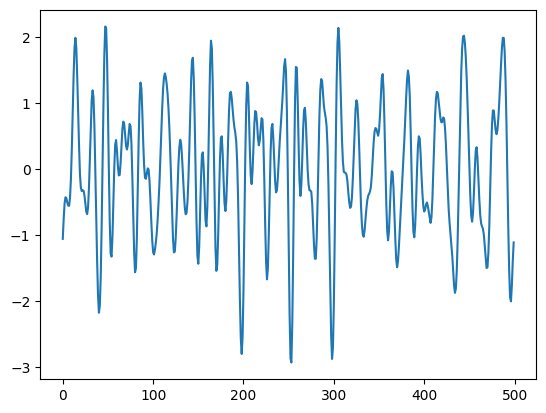

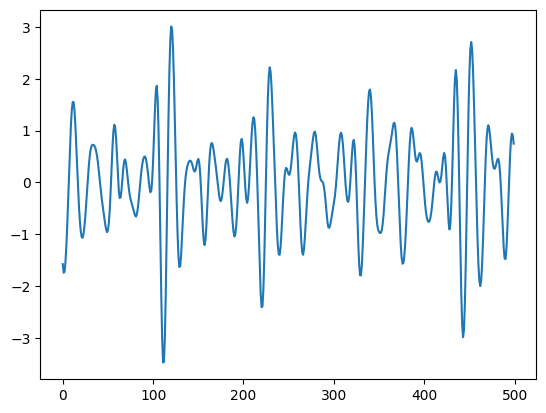

In [30]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

signal_index = 25

plt.figure()
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.figure()
    plt.plot(c_x_train[signal_index], label="class " + str(c))
    plt.show()

**Data pre-processing - timesteps / chunks**

In [31]:
# convert the data into the required CNN -format
# usually the easiest approach is to modify
# your own dataset to follow the data format used by another example
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [32]:
x_train

array([[[-0.79717168],
        [-0.66439208],
        [-0.37301463],
        ...,
        [-0.66439208],
        [-1.0737958 ],
        [-1.5643427 ]],

       [[ 0.80485472],
        [ 0.63462859],
        [ 0.37347448],
        ...,
        [-0.71488505],
        [-0.56044294],
        [-0.31908642]],

       [[ 0.7279851 ],
        [ 0.11128392],
        [-0.49912439],
        ...,
        [ 0.39446303],
        [ 0.33940042],
        [ 0.25539062]],

       ...,

       [[-0.57005428],
        [-0.33316523],
        [-0.29351853],
        ...,
        [-1.3937145 ],
        [-0.94273327],
        [-0.27072168]],

       [[ 2.0067321 ],
        [ 2.0791499 ],
        [ 2.0220362 ],
        ...,
        [-0.43214504],
        [-0.44123126],
        [-0.28070891]],

       [[-0.12524091],
        [-0.32536268],
        [-0.48823697],
        ...,
        [ 0.55576053],
        [ 0.57445102],
        [ 0.57311598]]], shape=(3601, 500, 1))

In [33]:
num_classes = len(np.unique(y_train))

In [34]:
# CNN networks usually benefit from SHUFFLING the training data
# NOTE! ONLY SHUFFLE TRAINING DATA; NEVER SHUFFLE TESTING DATA
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

In [ ]:
# out of convenience, change -1 to 0
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

**Create a CNN-network**